In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
import re
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AirlineCustSatis.csv')

In [3]:
# format columns name
def format_column_names(df):
    """
    Format all column names in a DataFrame to snake_case.

    Parameters:
        df (pandas.DataFrame): DataFrame whose column names are to be formatted.

    Returns:
        pandas.DataFrame: DataFrame with column names formatted to snake_case.
    """
    formatted_columns = [col.replace(' ', '_').lower() for col in df.columns]
    df.columns = formatted_columns
    return df

In [4]:
df = format_column_names(df)

In [5]:
df.head()

,satisfaction,gender,customer_type,age,type_of_travel,class,flight_distance,seat_comfort,departure/arrival_time_convenient,food_and_drink,...,online_support,ease_of_online_booking,on-board_service,leg_room_service,baggage_handling,checkin_service,cleanliness,online_boarding,departure_delay_in_minutes,arrival_delay_in_minutes
0,0,Male,Loyal Customer,48,Personal Travel,Eco Plus,1201,1,0,0,...,5,5,5,5,4,4,5,5,0,0.0
1,0,Male,Loyal Customer,30,Personal Travel,Eco,1582,1,0,0,...,1,1,2,4,3,5,1,1,0,2.0
2,0,Male,Loyal Customer,19,Personal Travel,Eco,1737,1,0,0,...,1,1,4,4,5,3,5,1,0,0.0
3,0,Male,Loyal Customer,13,Personal Travel,Eco,1351,1,0,0,...,5,5,5,2,5,4,4,5,4,2.0
4,0,Male,Loyal Customer,31,Personal Travel,Eco,1109,1,0,0,...,4,4,3,3,4,3,4,4,0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15190 entries, 0 to 15189
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   satisfaction                       15190 non-null  int64  
 1   gender                             15190 non-null  object 
 2   customer_type                      15190 non-null  object 
 3   age                                15190 non-null  int64  
 4   type_of_travel                     15190 non-null  object 
 5   class                              15190 non-null  object 
 6   flight_distance                    15190 non-null  int64  
 7   seat_comfort                       15190 non-null  int64  
 8   departure/arrival_time_convenient  15190 non-null  int64  
 9   food_and_drink                     15190 non-null  int64  
 10  gate_location                      15190 non-null  int64  
 11  inflight_wifi_service              15190 non-null  int

In [7]:
df.dropna(inplace = True)

In [8]:
df.apply(lambda col: col.unique())

satisfaction                                                                    [0, 1]
gender                                                                  [Male, Female]
customer_type                                      [Loyal Customer, disloyal Customer]
age                                  [48, 30, 19, 13, 31, 60, 70, 25, 47, 24, 29, 3...
type_of_travel                                      [Personal Travel, Business travel]
class                                                        [Eco Plus, Eco, Business]
flight_distance                      [1201, 1582, 1737, 1351, 1109, 3434, 2193, 235...
seat_comfort                                                        [1, 2, 4, 3, 5, 0]
departure/arrival_time_convenient                                   [0, 1, 2, 3, 4, 5]
food_and_drink                                                      [0, 1, 2, 3, 4, 5]
gate_location                                                       [1, 3, 4, 2, 5, 0]
inflight_wifi_service                      

# EDA

In [23]:
df.columns

Index(['satisfaction', 'gender', 'customer_type', 'age', 'type_of_travel',
       'class', 'flight_distance', 'seat_comfort',
       'departure/arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes', 'arrival_delay_in_minutes', 'clusters'],
      dtype='object')

In [26]:
# Calculate air_score as the average of selected columns
df['air_score'] = df[['seat_comfort', 'inflight_wifi_service', 'inflight_entertainment', 'on-board_service', 
                      'leg_room_service', 'cleanliness', 'food_and_drink']].mean(axis=1)

# Calculate ground_score as the average of selected columns
df['ground_score'] = df[['departure/arrival_time_convenient', 'gate_location', 'baggage_handling', 
                         'checkin_service']].mean(axis=1)

# Calculate online_support_score as the average of online_support column
df['online_support_score'] = df[['online_support', 'online_boarding','ease_of_online_booking']].mean(axis=1)


In [9]:
numerical_columns = ['age','flight_distance','departure_delay_in_minutes','arrival_delay_in_minutes']
categorical_columns = [col for col in df.columns if col not in numerical_columns]

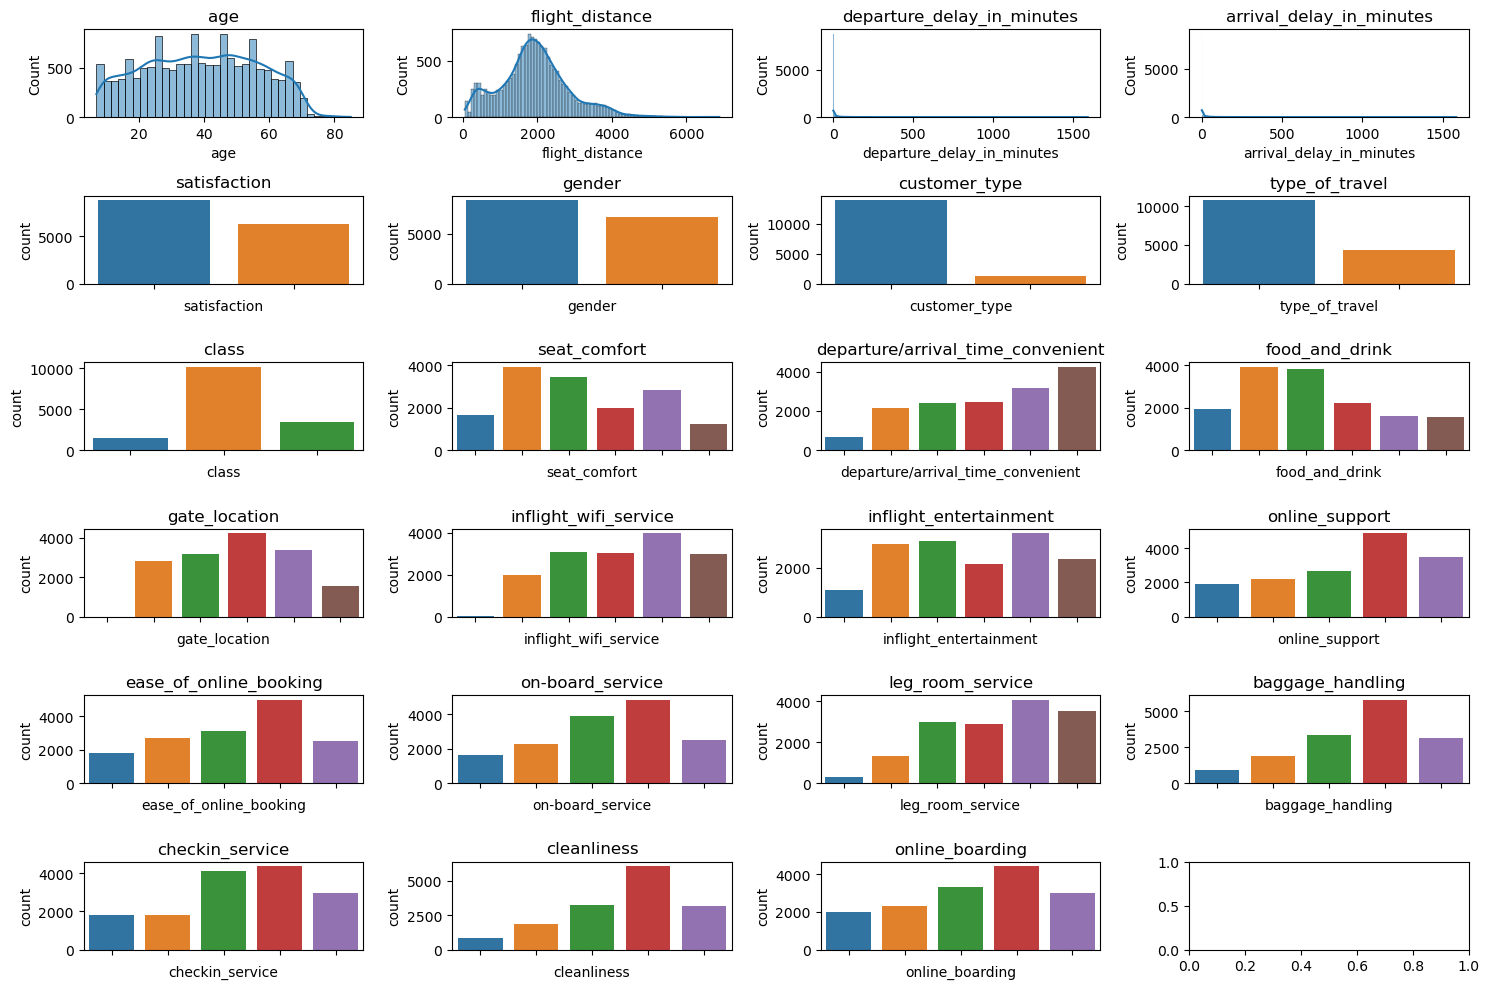

In [10]:
# Plotting subplots
num_rows = 6
num_cols = (len(numerical_columns) + len(categorical_columns) + num_rows - 1) // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(df[column], ax=axes[row][col], kde=True)
    axes[row][col].set_title(column)

for i, column in enumerate(categorical_columns):
    row = (i + len(numerical_columns)) // num_cols
    col = (i + len(numerical_columns)) % num_cols
    sns.countplot(data=df, x=column, ax=axes[row][col])
    axes[row][col].set_title(column)
    axes[row][col].set_xticklabels([])  # Remove x-axis labels

plt.tight_layout()
plt.show()


## Bivariate

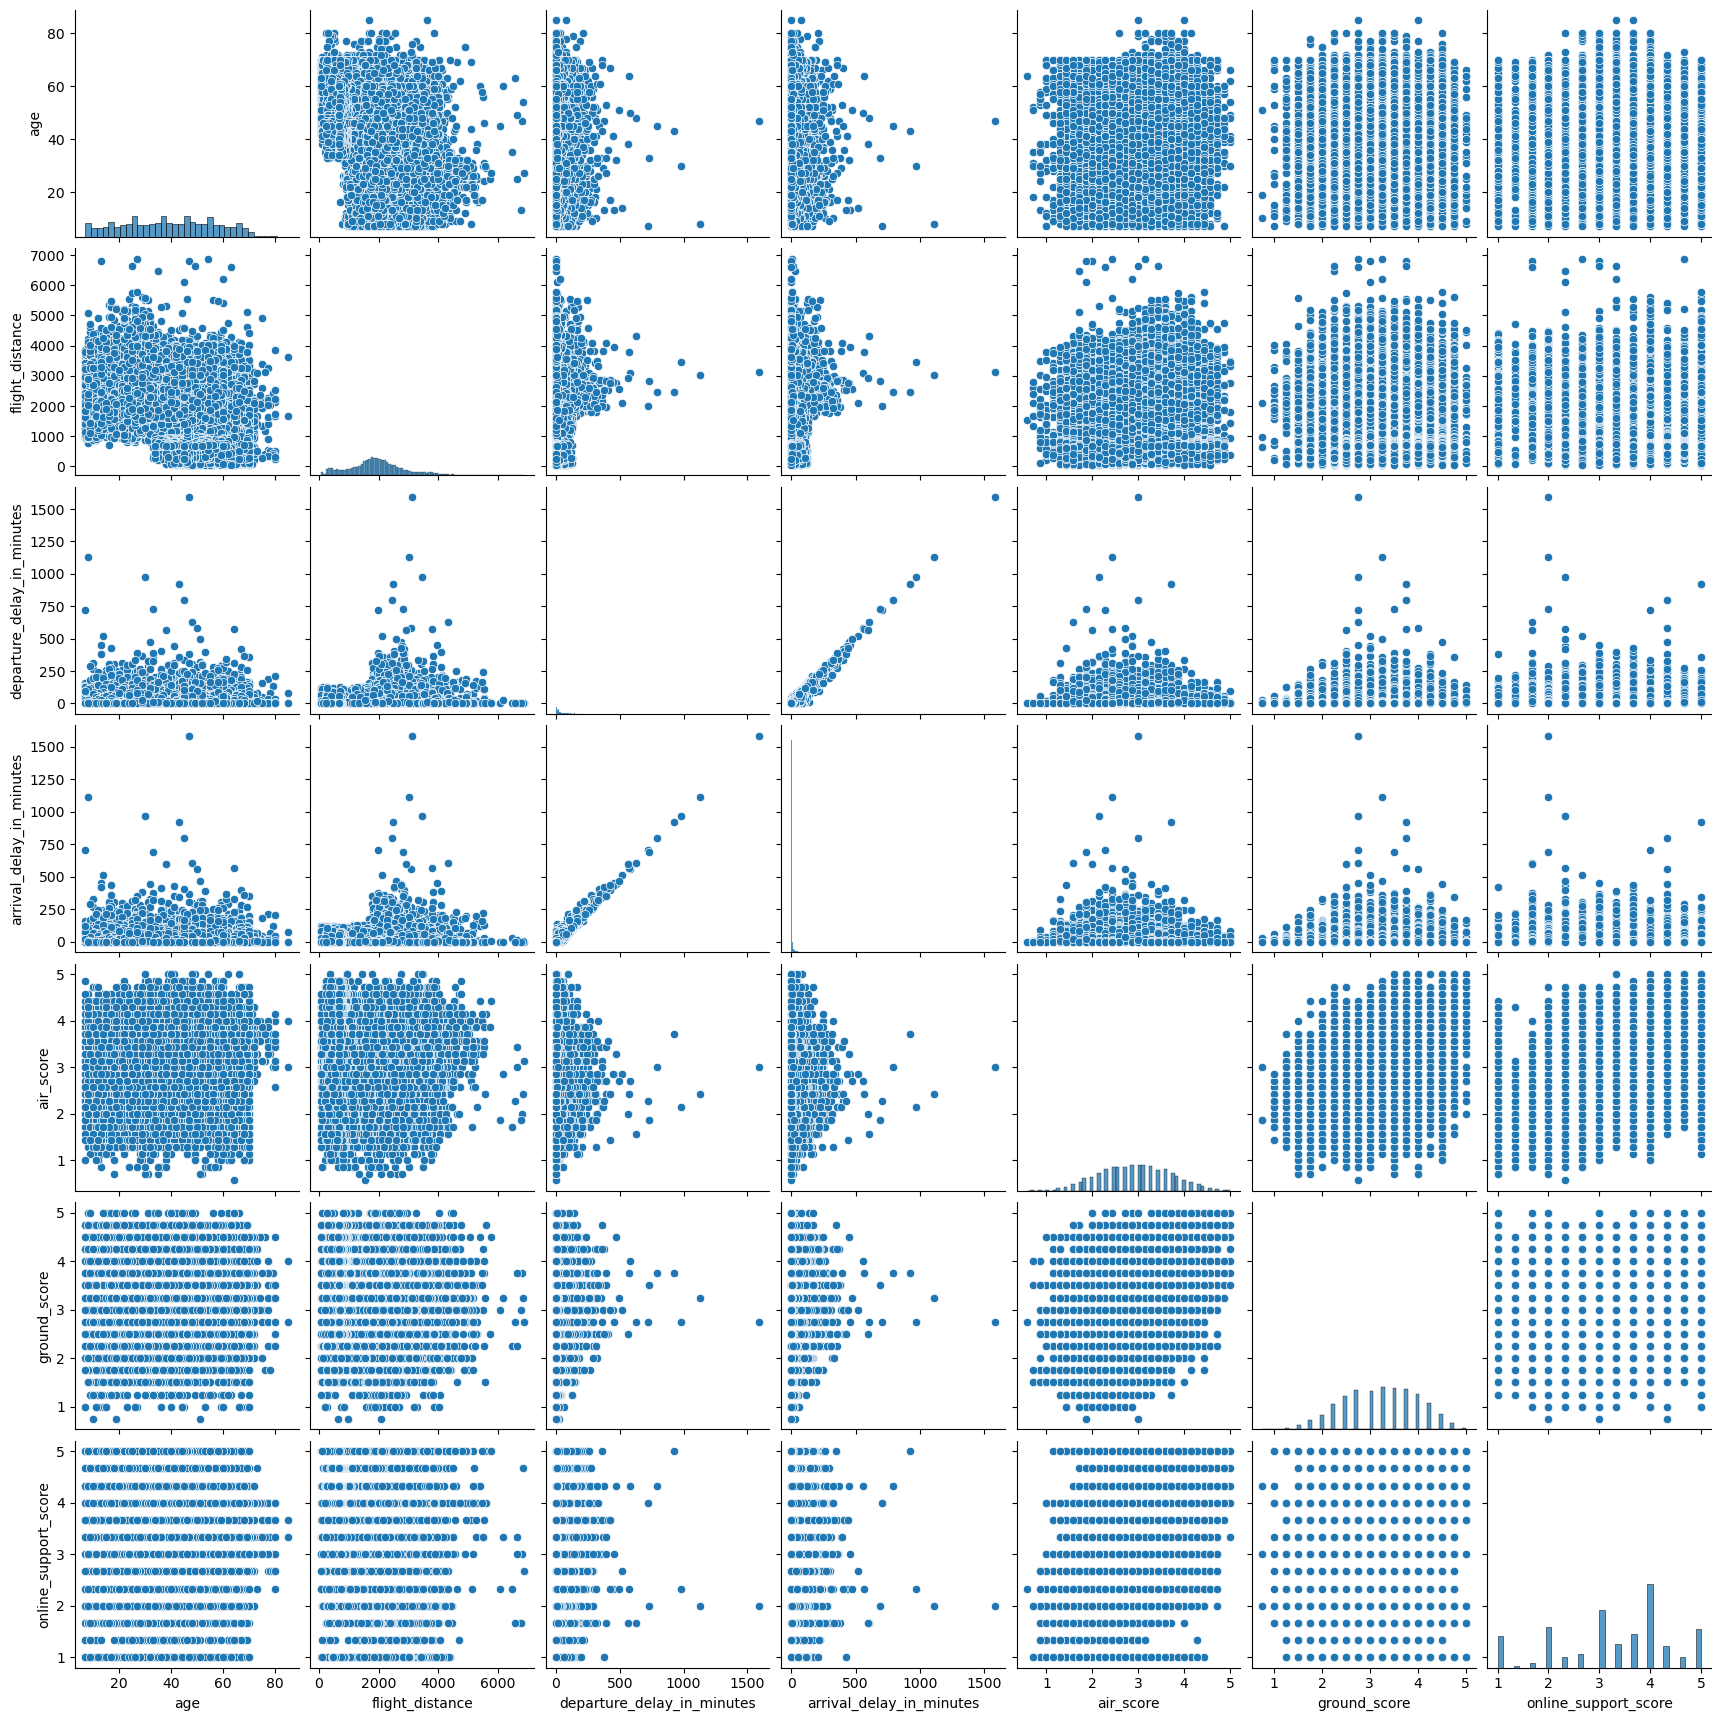

In [31]:
sns.pairplot(df[numerical_columns+['air_score','ground_score','online_support_score']])

## Mutivariate 

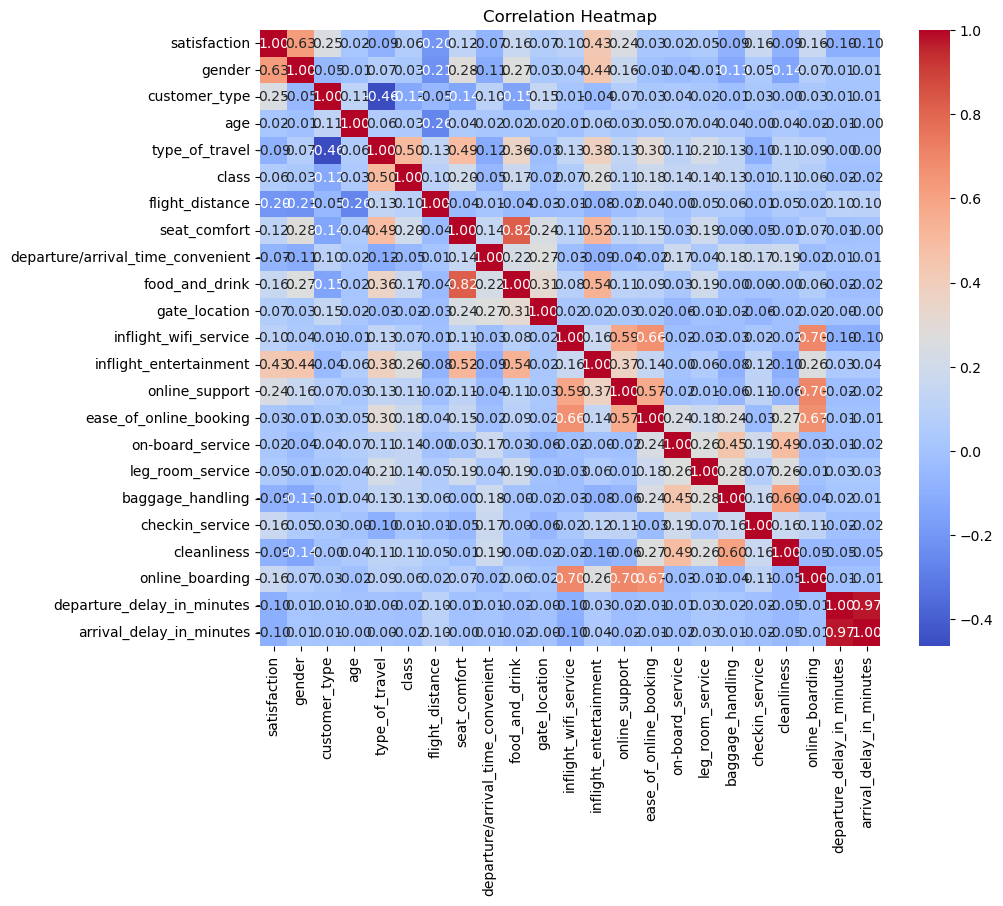

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Model

In [12]:
# Mapping for gender
gender_mapping = {'Male': 0, 'Female': 1}
df['gender'] = df['gender'].map(gender_mapping)

# Mapping for customer_type
customer_type_mapping = {'Loyal Customer': 1, 'disloyal Customer': 0}
df['customer_type'] = df['customer_type'].map(customer_type_mapping)

In [13]:
# Mapping for type_of_travel
type_of_travel_mapping = {'Personal Travel': 0, 'Business travel': 1}
df['type_of_travel'] = df['type_of_travel'].replace(type_of_travel_mapping)

# Mapping for class
class_mapping = {'Eco Plus': 0, 'Eco': 1, 'Business': 2}
df['class'] = df['class'].replace(class_mapping)

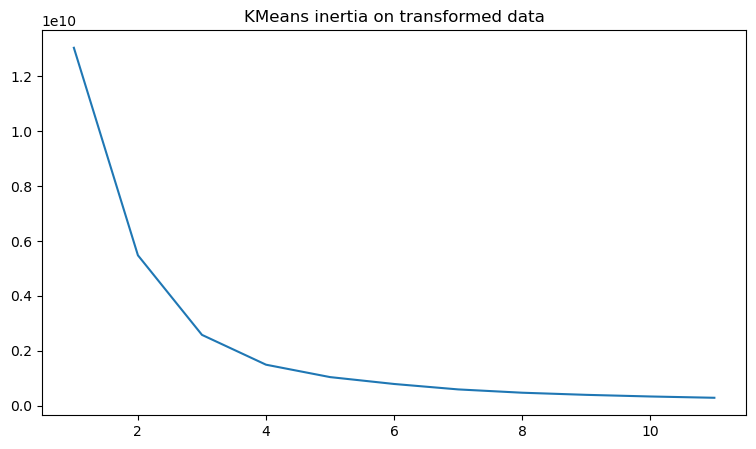

In [15]:
#Determine the number of clusters 
inertia_t = []
for i in range(1, 12):
    km = KMeans(n_clusters=i).fit(df)
    inertia_t.append(km.inertia_)

#Plot to check the suggested number of clusters
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
sns.lineplot(x=range(1,12), y=inertia_t)
plt.title('KMeans inertia on transformed data')
plt.show()

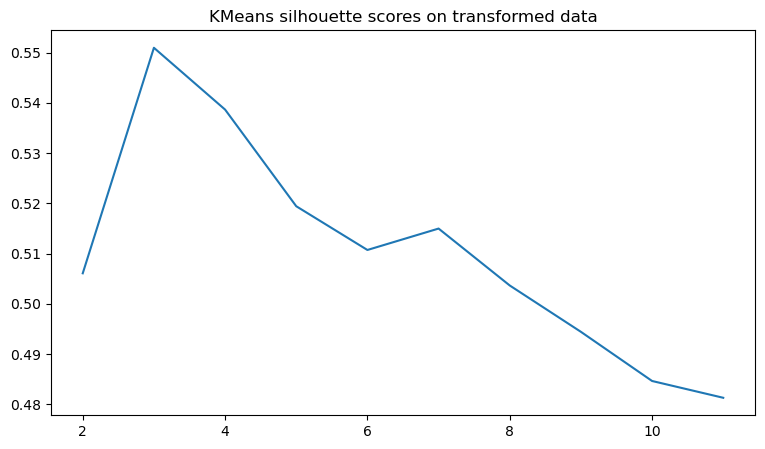

In [16]:
silhouette_scores = []

for i in range(2, 12):  # Considering clusters from 2 to 11
    km = KMeans(n_clusters=i)
    km.fit(df)
    silhouette_scores.append(silhouette_score(df, km.labels_))

#Plot to check the suggested number of clusters
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
sns.lineplot(x=range(2,12), y=silhouette_scores)
plt.title('KMeans silhouette scores on transformed data')
plt.show()

In [ ]:
# Chose number of cluster = 3

In [17]:
#Build the model
kmeans3=KMeans(n_clusters=3,n_init=10,max_iter=500)
kmeans3.fit(df)

KMeans(max_iter=500, n_clusters=3, n_init=10)

In [18]:
#Add the clusters into the initial dataframe (centers)
df['clusters']=kmeans3.labels_ 

# take a look at the cluster center
kmeans3.cluster_centers_

array([[3.30810433e-01, 3.61434560e-01, 8.97997205e-01, 3.60435491e+01,
        2.49417792e-01, 1.05426176e+00, 1.99989998e+03, 2.12459245e+00,
        3.24673964e+00, 2.03714485e+00, 2.80181649e+00, 3.15975780e+00,
        2.45237541e+00, 3.29972054e+00, 3.19678621e+00, 3.25395901e+00,
        3.27515137e+00, 3.57743363e+00, 3.32557056e+00, 3.60211924e+00,
        3.25034932e+00, 1.59788076e+01, 1.65178156e+01],
       [6.32125665e-01, 6.65062072e-01, 9.63516595e-01, 4.77914872e+01,
        2.66784900e-01, 1.15100076e+00, 8.14276919e+02, 2.52064859e+00,
        3.13351913e+00, 2.35545984e+00, 2.92399291e+00, 3.25158348e+00,
        3.19052445e+00, 3.53204966e+00, 3.26349126e+00, 3.33316443e+00,
        3.25563719e+00, 3.45604256e+00, 3.33823157e+00, 3.49049911e+00,
        3.28173296e+00, 1.03633139e+01, 1.09632632e+01],
       [3.68766911e-01, 3.82296096e-01, 9.33900271e-01, 3.59555470e+01,
        4.32160804e-01, 1.31465017e+00, 3.38697565e+03, 2.38538848e+00,
        3.16505605e+00

In [27]:
import plotly.express as px

# Assuming df is your DataFrame with the specified columns

fig = px.scatter_3d(df, x='air_score', y='ground_score', z='online_support_score', color='clusters',
                    symbol='clusters', opacity=0.7, size_max=10,
                    title='3D Scatter Plot of Clusters', color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()


In [22]:
fig = px.scatter(df, x='flight_distance', y='departure_delay_in_minutes', color='clusters',
                    symbol='clusters', opacity=0.7, size_max=10,
                    title='3D Scatter Plot of Clusters', color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()
